In [ ]:
# install from recent commit
! python -m pip install git+https://github.com/rlouf/mcx@5bf7f13646c26ccbecc24b7148a5e270e75ac8bf

In [2]:
import jax
from jax import numpy as jnp
import numpy as np
import arviz as az

import mcx
import mcx.distributions as dist

In [ ]:
lam = 5.
y = np.random.poisson(lam=lam, size=2000)

In [ ]:
from jax import lax

In [ ]:
rng_key = jax.random.PRNGKey(0)

@mcx.model
def poisson_model():
    scale <~ dist.Gamma(2,0,1)
    y <~ dist.Poisson(scale)
    return y

# Sample from the model posterior distribution using HMC
hmc_kernel = mcx.HMC(num_integration_steps=100)

In [ ]:
# args = (X, 3.)
observations = {'y': y}
sampler = mcx.sampler(
   rng_key,
   poisson_model,
   (), #args
   observations,
   hmc_kernel
)
trace = sampler.run()

In [ ]:
np.array(trace['scale']).mean()

In [ ]:
az.plot_trace(trace)

## Switchpoint model

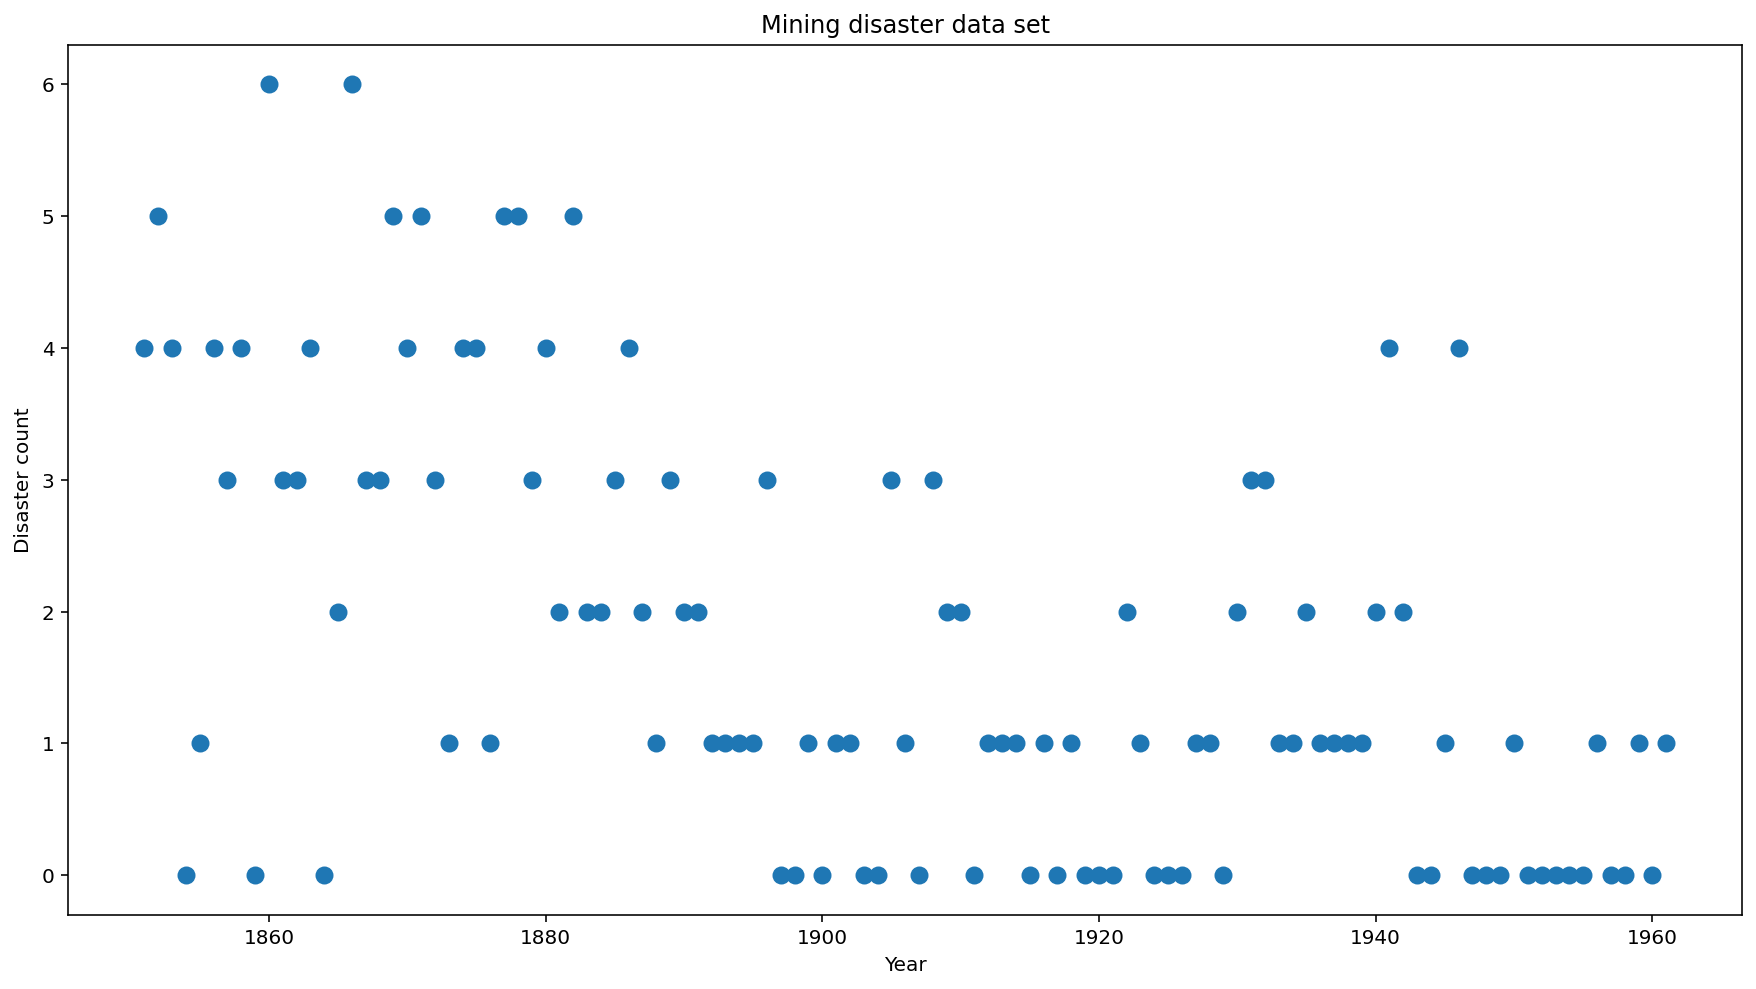

In [3]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,8)
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
disaster_data = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)
plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel('Disaster count')
plt.xlabel('Year')
plt.title('Mining disaster data set')
plt.show()

In [113]:
@mcx.model
def disaster_rate_model(t, tl=1851, th=1961, rl=1., re=1.):
    s <~ dist.Uniform(tl, th)
    l <~ dist.Exponential(rl)
    e <~ dist.Exponential(re)
    rt = e + (l-e)/(1.+jnp.exp(-(t-s)))
    Dt <~ dist.Poisson(rt)
    return Dt

In [114]:
rng_key = jax.random.PRNGKey(5)

In [115]:
years.min(), years.max()
# disaster_rate.logpdf(s=1890, e=3, l=0.9,t = 1888, Dt = disaster_data)

(1851, 1961)

In [117]:
observations = {'Dt': disaster_data, }
hmc_kernel = mcx.HMC(num_integration_steps=100)
sampler = mcx.sampler(
   rng_key,
   disaster_rate_model,
   (years.astype(np.float32),), #args
   observations,
   hmc_kernel
)
trace = sampler.run()

sampler: build the loglikelihood
sampler: find the initial states
sampler: build and compile the inference kernel


Warming up 4 chains for 1000 steps: 100%|██████████| 1000/1000 [00:04<00:00, 237.21samples/s]


In [129]:
np.isnan(np.array(trace.values()['e'])).sum()

0

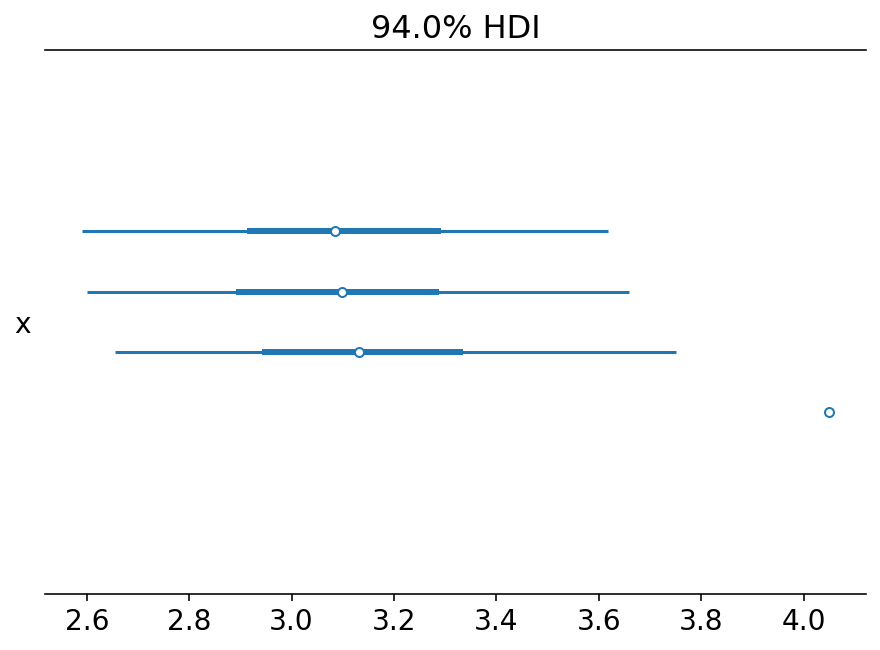

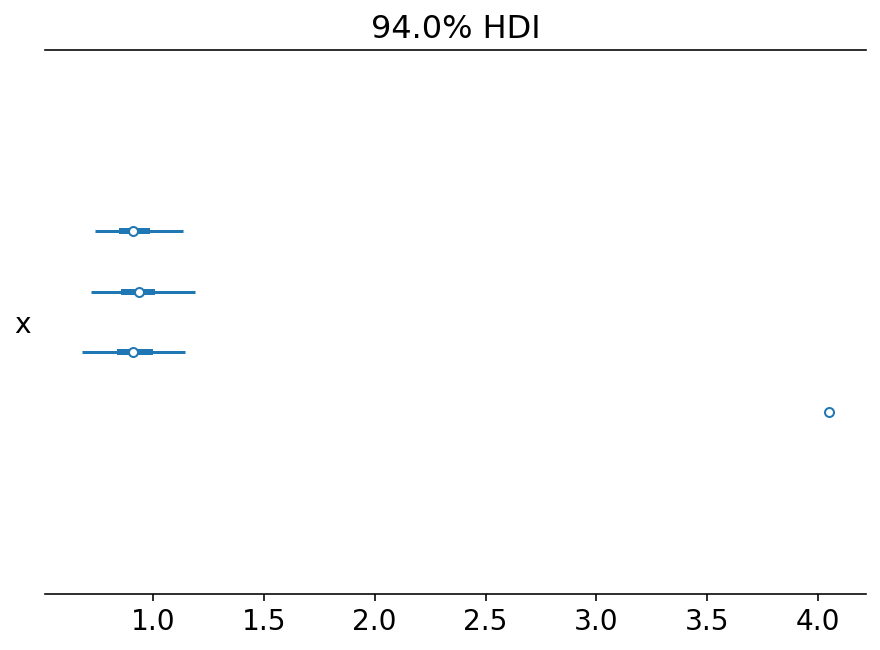

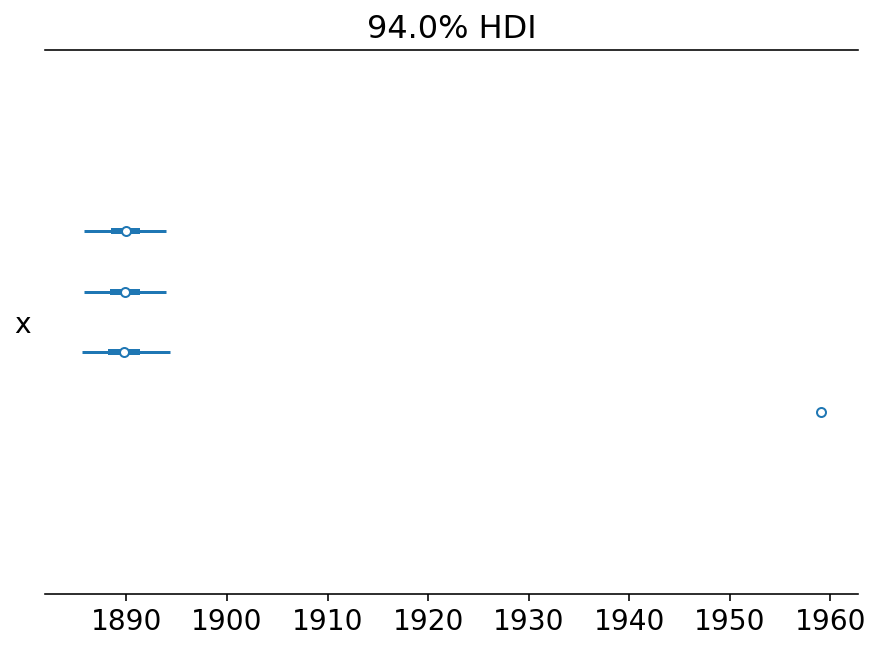

In [139]:
for variable in ['e', 'l', 's']:
    az.plot_forest(np.array(trace.values()[variable]))